<a href="https://colab.research.google.com/github/Jacob-Francis/SWSG_repo/blob/main/Colab_nb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from matplotlib.animation import FuncAnimation

In [2]:
#!apt-get install cuda=10.2.89-1
# %matplotlib inline

# !pip install pykeops[colab] > install.log
# !pip install geomloss[full]
# !apt-get install ffmpeg

import torch
import numpy as np
from geomloss import SamplesLoss
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Device configuration
#pytorch.cuda.alloc.conf = expandable_segments
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_dtype(torch.float64)
# torch.set_default_device(device)

In [7]:
def Lloyds(f, N, k=10, Nsteps=3,scali=0.5, epsilon=0.01):

    # Generate initial grid of points for x
    grid_size = int(N**0.5)  # Assuming N is a perfect square
    x = (torch.rand(N, 2,device=device)).detach().requires_grad_(True) # Random points in [-1, 1]
    # Generate fine grid of points y with k*N points
    fine_grid_size = int((k * N)**0.5)
    y = torch.stack(torch.meshgrid(torch.linspace(0, 1, fine_grid_size,device=device),
                                   torch.linspace(0, 1, fine_grid_size,device=device)), dim=-1).reshape(-1, 2)
    y = y[:k * N]

    # Compute weights b proportional to f(y)
    b = f(y)
    b /= b.sum()  # Normalize to make b a probability distribution

    # Uniform weights for points x
    a = torch.full((N,), 1 / N,device=device)

    # Define the entropic OT loss function
    loss_fn = SamplesLoss("sinkhorn", p=2,scaling=scali, blur=epsilon**0.5)

    # Iterative Lloyd's algorithm
    for _ in range(Nsteps):
        # Compute the transport map between x and (y, b)
        loss = loss_fn(a,x,b, y)
        grad = torch.autograd.grad(loss, x)[0]
        x=x.clone().detach().requires_grad_(True)

        # Move points in the direction of the gradient to minimize OT cost
        with torch.no_grad():
            x -= N * grad  # Adjust x by moving in gradient direction

    return x.detach()  # Return points that fit the density function

def init_gaussian(N, k=10, epsilon=0.001,Nsteps=3,scali=0.99,std=[0.2,0.2]):
    def gaussian_density(points, mean=[0, 0], std=[0.1, 0.1]):
        """Evaluates a Gaussian function at given points."""
        dist = torch.distributions.MultivariateNormal(
            torch.tensor(mean,device=device),
            torch.diag(torch.tensor(std,device=device))**2
        )
        return torch.exp(dist.log_prob(points))
    # Run Lloyd's algorithm
    f = lambda y: gaussian_density(y, mean=[0.5, 0.5], std=[0.2, 0.2])  # Gaussian density function
    points = Lloyds(f, N, k=k, Nsteps=Nsteps, epsilon=epsilon)
    return points




In [6]:
# loss = SamplesLoss('sinkhorn', p=2, blur=0.01)
# lr = 0.5
# sigma = 0.01


In [8]:

def x_adaptation(G, X, Y, alpha, loss, Y_dense, sigma=0.01, tol=1e-2, ):
    err = torch.inf
    count = 0 
    while err > tol:
        # solve one W2 (G, X)
        # L_gx = loss(G, X)
        # [h_gx] = torch.autograd.grad(L_gx, [X])
        h_gx = (X - G) / N
        # solve W2 (X, Y)
        L_xy = loss(torch.ones_like(X[:, 0]) / len(X[:,0]), X, alpha, Y)
        L_yy = loss(torch.ones_like(Y_dense[:, 0])/ len(Y_dense[:,0]), Y_dense, alpha, Y)
        [h_xy] = torch.autograd.grad(L_xy, [X])
        [alpha_grad_1] = torch.autograd.grad(L_xy, [alpha])
        [alpha_grad_2] = torch.autograd.grad(L_yy, [alpha])
        
        # update X
        update = h_gx + h_xy/sigma
        X = X - lr*N*update  / (1 + 1/sigma)
        
        # update alpha
        update = alpha_grad_2 + alpha_grad_1/sigma
        alpha = alpha - lr*N*update / (1 + 1/sigma)

        err = torch.linalg.norm(N*update / (1 + 1/sigma), ord=float('inf'))
        print(count, err)

        count += 1
    print(count, err)
    return X,  alpha

def g_speed(G, X, dt, J):
    G = G + dt * (G - X.detach()) @-J
    return G

def x_guess(G, X, dt, J):
    X = X + dt * (G - X.detach()) @-J
    return X


# Dyanmics


# plt.figure(figsize=(8, 6))
# plt.scatter(G[:, 0].cpu(), G[:, 1].cpu(), color='blue', label='G_i', alpha=0.7)
# plt.scatter(Y[:, 0].cpu(), Y[:, 1].cpu(), color='green', s=10, label='Y_j', alpha=0.5)
# plt.scatter(X[:, 0].detach().cpu(), X[:, 1].detach().cpu(), color='red', marker='x', s=80)
# plt.legend()
# plt.xlabel('X-axis')
# plt.ylabel('Y-axis')
# plt.show()

In [18]:
dt = 0.2
T = 1
N = 10
M = 10 
M_dense = 20

loss = SamplesLoss('sinkhorn', p=2, blur=0.001, scaling=0.9)
lr = 0.5

#initialisations
grid_size = int(M**0.5)
grid = torch.linspace(0,1, grid_size)
y1, y2 = torch.meshgrid(grid, grid, indexing='ij')
Y = torch.stack([y1.flatten(), y2.flatten()], dim=1)

G = init_gaussian(N,std=[0.3,0.3])
J = -1*torch.Tensor([[0, 1], [-1, 0 ]]).type_as(G)

Y = Y.type_as(G)
X = G.clone().requires_grad_(True)
alpha = torch.ones_like(Y[:,0]).requires_grad_(True)

# Densee grid
grid_size = int(M_dense**0.5)
grid = torch.linspace(0,1, grid_size)
y1, y2 = torch.meshgrid(grid, grid, indexing='ij')
Y_dense = torch.stack([y1.flatten(), y2.flatten()], dim=1).type_as(G)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


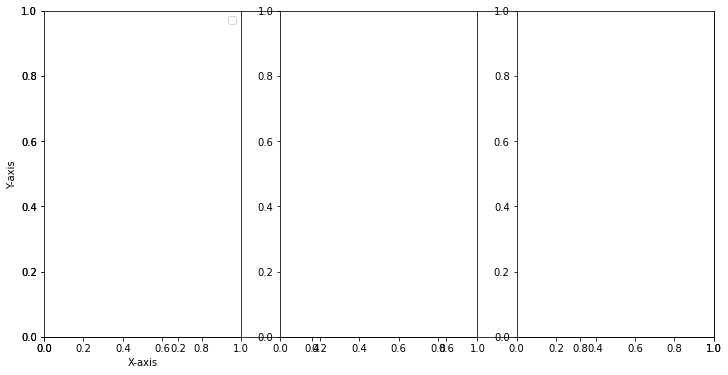

In [ ]:
# Set up the figure and axis for animation
fig, ax = plt.subplots(figsize=(12, 6))
ax = fig.add_subplot(131)
ax1 = fig.add_subplot(132)
ax2 = fig.add_subplot(133)

# scat_G = ax.scatter(G[:, 0].cpu(), G[:, 1].cpu(), color='blue', label='G_i', alpha=0.7)
# scat_Y = ax.scatter(Y[:, 0].cpu(), Y[:, 1].cpu(), color='green', s=5, label='Y_j', alpha=0.5)
# scat_X = ax.scatter(X[:, 0].detach().cpu(), X[:, 1].detach().cpu(), color='red', marker='x', s=80)

# Initialize the plot labels
ax.legend()
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')

# Update function for animation
def anim_function(i):
    global X, G, alpha
    
    ax.cla()
    ax1.cla()
    ax2.cla()
    
    ax.set(xlim=[-0.5, 1.5], ylim=[-0.5, 1.5])
    ax.set_title((torch.linalg.norm(G-X)**2).item())
    
    # Update X and G
    X, alpha = x_adaptation(G, X, Y, alpha=alpha, Y_dense=Y_dense, sigma=sigma, loss=loss, tol=1e-5)
    G = g_speed(G, X, dt, J)
    X = x_guess(G, X, dt, J)
    
    # Update scatter plot data without clearing the figure
    scat_G = ax.scatter(G[:, 0].cpu(), G[:, 1].cpu(), color='blue', label='G_i', alpha=0.7)
    # scat_Y = ax.scatter(Y[:, 0].cpu(), Y[:, 1].cpu(), color='green', s=10, label='Y_j', alpha=0.5)
    scat_X = ax1.scatter(X[:, 0].detach().cpu(), X[:, 1].detach().cpu(), color='red', s=10)
    scat_X = ax2.scatter(Y[:, 0].detach().cpu(), Y[:, 1].detach().cpu(), c=alpha.detach().cpu(), s=10)

    return scat_G, scat_X

In [20]:
anim_function(1)
# print(count)

0 tensor(91.2846, device='cuda:0')
1 tensor(4131488.4026, device='cuda:0')
2 tensor(691.7617, device='cuda:0')
3 tensor(691.7013, device='cuda:0')
4 tensor(691.6671, device='cuda:0')
5 tensor(691.6463, device='cuda:0')
6 tensor(691.6325, device='cuda:0')
7 tensor(691.6221, device='cuda:0')
8 tensor(691.6134, device='cuda:0')
9 tensor(691.6056, device='cuda:0')
10 tensor(691.5983, device='cuda:0')
11 tensor(691.5911, device='cuda:0')
12 tensor(691.5841, device='cuda:0')
13 tensor(691.5771, device='cuda:0')
14 tensor(691.5702, device='cuda:0')
15 tensor(691.5632, device='cuda:0')
16 tensor(691.5563, device='cuda:0')
17 tensor(691.5494, device='cuda:0')
18 tensor(691.5424, device='cuda:0')
19 tensor(691.5355, device='cuda:0')
20 tensor(691.5285, device='cuda:0')
21 tensor(691.5216, device='cuda:0')
22 tensor(691.5147, device='cuda:0')
23 tensor(691.5077, device='cuda:0')
24 tensor(691.5008, device='cuda:0')
25 tensor(691.4939, device='cuda:0')
26 tensor(691.4869, device='cuda:0')
27 tenso

KeyboardInterrupt: 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


KeyboardInterrupt: 

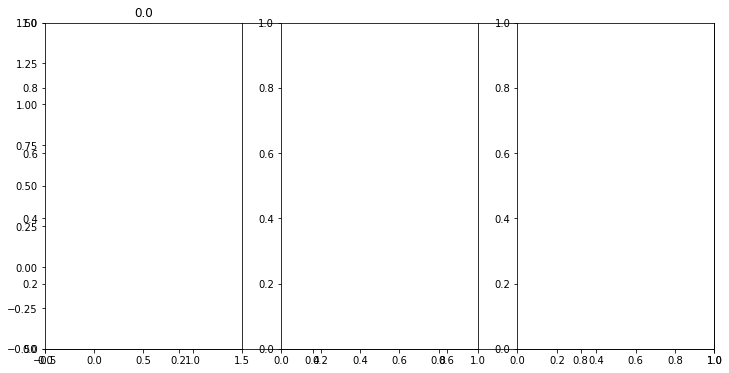

In [15]:
# Set up the figure and axis for animation
fig, ax = plt.subplots(figsize=(12, 6))
ax = fig.add_subplot(131)
ax1 = fig.add_subplot(132)
ax2 = fig.add_subplot(133)

# scat_G = ax.scatter(G[:, 0].cpu(), G[:, 1].cpu(), color='blue', label='G_i', alpha=0.7)
# scat_Y = ax.scatter(Y[:, 0].cpu(), Y[:, 1].cpu(), color='green', s=5, label='Y_j', alpha=0.5)
# scat_X = ax.scatter(X[:, 0].detach().cpu(), X[:, 1].detach().cpu(), color='red', marker='x', s=80)

# Initialize the plot labels
ax.legend()
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')

# Update function for animation
def anim_function(i):
    global X, G, alpha
    
    ax.cla()
    ax1.cla()
    ax2.cla()
    
    ax.set(xlim=[-0.5, 1.5], ylim=[-0.5, 1.5])
    ax.set_title((torch.linalg.norm(G-X)**2).item())
    
    # Update X and G
    X, alpha = x_adaptation(G, X, Y, alpha=alpha, Y_dense=Y_dense, sigma=0.0001, loss=loss, tol=1e-5)
    G = g_speed(G, X, dt, J)
    X = x_guess(G, X, dt, J)
    
    # Update scatter plot data without clearing the figure
    scat_G = ax.scatter(G[:, 0].cpu(), G[:, 1].cpu(), color='blue', label='G_i', alpha=0.7)
    # scat_Y = ax.scatter(Y[:, 0].cpu(), Y[:, 1].cpu(), color='green', s=10, label='Y_j', alpha=0.5)
    scat_X = ax1.scatter(X[:, 0].detach().cpu(), X[:, 1].detach().cpu(), color='red', s=10)
    scat_X = ax2.scatter(Y[:, 0].detach().cpu(), Y[:, 1].detach().cpu(), c=alpha.detach().cpu(), s=10)

    return scat_G, scat_X

# Create the animation
num_frames = int(T/dt)  # Number of frames for the GIF
anim = FuncAnimation(fig, anim_function, frames=num_frames, interval=300, blit=True)

# Save animation directly as a GIF using PillowWriter
anim.save('new_alpha.gif')#, writer=PillowWriter(fps=3))  # Adjust fps as needed


[1.1 1.1 1.1 ... 1.1 1.1 1.1]
[1.1 1.1 1.1 ... 1.1 1.1 1.1]
[1.1 1.1 1.1 ... 1.1 1.1 1.1]
[1.1 1.1 1.1 ... 1.1 1.1 1.1]
[1.1 1.1 1.1 ... 1.1 1.1 1.1]
[1.1 1.1 1.1 ... 1.1 1.1 1.1]
[1.1 1.1 1.1 ... 1.1 1.1 1.1]
[1.1 1.1 1.1 ... 1.1 1.1 1.1]
[1.1 1.1 1.1 ... 1.1 1.1 1.1]
[1.1 1.1 1.1 ... 1.1 1.1 1.1]
[1.1 1.1 1.1 ... 1.1 1.1 1.1]
[1.1 1.1 1.1 ... 1.1 1.1 1.1]
[1.1 1.1 1.1 ... 1.1 1.1 1.1]
[1.1 1.1 1.1 ... 1.1 1.1 1.1]
[1.1 1.1 1.1 ... 1.1 1.1 1.1]
[1.1 1.1 1.1 ... 1.1 1.1 1.1]
[1.1 1.1 1.1 ... 1.1 1.1 1.1]
[1.1 1.1 1.1 ... 1.1 1.1 1.1]
[1.1 1.1 1.1 ... 1.1 1.1 1.1]
[1.1 1.1 1.1 ... 1.1 1.1 1.1]


ValueError: 'c' argument has 24820 elements, which is inconsistent with 'x' and 'y' with size 4969.

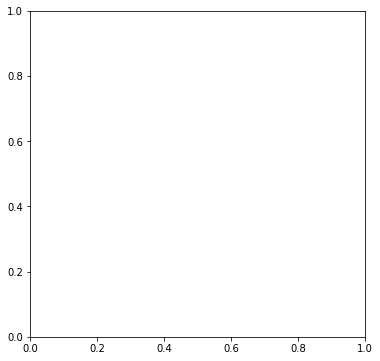

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def generate_uniform_annulus(R_inner, R_outer, num_radial_points):
    # Radial distances spaced by square root to maintain uniform density
    r = np.linspace(np.sqrt(R_inner), np.sqrt(R_outer), num_radial_points)**2

    x_points = []
    y_points = []
    height = []

    def jet_h(r, a=0.1, b=10, c=(R_outer - R_inner) /2, d=1):
        return a * np.tanh(b * (x - c)) + d
    
    for radius in r:
        # Determine the number of points at this radius
        num_points_at_radius = int(2 * np.pi * radius / (R_outer - R_inner) * num_radial_points)

        # Angular positions for these points
        angles = np.linspace(0, 2 * np.pi, num_points_at_radius, endpoint=False)

        # Convert polar coordinates to Cartesian
        x_points.extend(radius * np.cos(angles))
        y_points.extend(radius * np.sin(angles))
        height.extend(jet_h(radius))

    # Jet

    return np.stack([np.array(x_points), np.array(y_points)], axis=-1), height

# Parameters
R_inner = 3.0       # Inner radius of the annulus
R_outer = 5.0       # Outer radius of the annulus
num_radial_points = 20   # Number of radial steps

# Generate uniformly spaced annulus points
xy, h = generate_uniform_annulus(R_inner, R_outer, num_radial_points)

# Plot the annulus
plt.figure(figsize=(6, 6))
p = plt.scatter(xy[:, 0], xy[:, 1], c=h, s=10, alpha=0.7)
plt.colorbar(p)
plt.gca().set_aspect('equal', adjustable='box')
plt.title("Uniformly Dense Annulus")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()


In [25]:
(np.sqrt(R_outer) - np.sqrt(R_inner)) / 2

0.2520085849654563

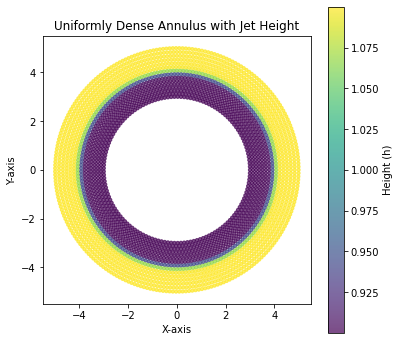

In [33]:
import numpy as np
import matplotlib.pyplot as plt

def generate_uniform_annulus(R_inner, R_outer, num_radial_points):
    # Radial distances spaced by square root to maintain uniform density
    r = np.linspace(np.sqrt(R_inner), np.sqrt(R_outer), num_radial_points)**2

    x_points = []
    y_points = []
    gx_points = []
    gy_points = []
    height = []
    f=1.0
    g=0.1
    a,b,c = 0.1, 10, (R_outer + R_inner) / 2
    d=1
    # Define jet height function
    def jet_h(r):
        return a * np.tanh(b * (r - c)) + d
    
    for radius in r:
        # Determine the number of points at this radius
        num_points_at_radius = int(2 * np.pi * radius / (R_outer - R_inner) * num_radial_points)

        # Angular positions for these points
        angles = np.linspace(0, 2 * np.pi, num_points_at_radius, endpoint=False)

        # Convert polar coordinates to Cartesian
        x_points.extend(radius * np.cos(angles))
        y_points.extend(radius * np.sin(angles))
        
        # Calculate height for each point at this radius
        height.extend([jet_h(radius)] * num_points_at_radius)
        G_i = radius + f**2 * g * a * b * (1 - np.tanh(b * (radius - c)) ** 2)
        gx_points.extend(G_i * np.cos(angles))
        gy_points.extend(G_i * np.sin(angles))

    # Stack x and y points into a single array for easy plotting
    return np.stack([np.array(x_points), np.array(y_points)], axis=-1), height,np.stack([np.array(gx_points), np.array(gy_points)], axis=-1)

# Parameters
R_inner = 3.0       # Inner radius of the annulus
R_outer = 5.0       # Outer radius of the annulus
num_radial_points = 15   # Number of radial steps

# Generate uniformly spaced annulus points
xy, h, Gxy = generate_uniform_annulus(R_inner, R_outer, num_radial_points)

# Plot the annulus
plt.figure(figsize=(6, 6))
p = plt.scatter(xy[:, 0], xy[:, 1], c=h, s=10, alpha=0.7, cmap='viridis')
plt.colorbar(p, label="Height (h)")
plt.gca().set_aspect('equal', adjustable='box')
plt.title("Uniformly Dense Annulus with Jet Height")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()


In [21]:
h

[1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1,
 1.1

In [ ]:
height